### Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

from cluster_optimizer import ClusterOptimizer

from feature_engineering_functions import ColumnsCombinator

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

import geopandas as gpd
import matplotlib.pyplot as plt

import country_converter as coco

### Loading the data

In [2]:
countries_df = pd.read_csv("data/countries.csv").set_index("country")

### Create pipeline templates

In [3]:
saldo_creator = ColumnsCombinator(arguments=["exports", "imports"],
                                  operators=["-"],
                                  new_column_name="saldo")
total_health_exp_est_creator= ColumnsCombinator(arguments=["health", "gdpp", "income"],
                                                operators=["*", "+"],
                                                new_column_name="total_health_exp")
# preprocessors
scaler = StandardScaler()
normalizer = Normalizer()
pca = PCA(n_components=4)

# models
kmeans = KMeans(random_state=0)
aggc = AgglomerativeClustering()
spc = SpectralClustering()

# pipelines
kmeans_pipe = make_pipeline(saldo_creator, total_health_exp_est_creator, scaler, normalizer, pca, kmeans)
aggc_pipe = make_pipeline(saldo_creator, total_health_exp_est_creator, scaler, normalizer, pca, aggc)
spc_pipe = make_pipeline(saldo_creator, total_health_exp_est_creator, scaler, pca, spc)

### Gridsearch: KMeans

In [4]:
from cluster_optimizer import ClusterOptimizer


kmeans_grid = [
    # feature engineering + scaling + PCA + KMeans
    {
    "normalizer": ['passthrough'],
    "kmeans__n_clusters": [3, 4, 5, 6]
    },
    # feature engineering + normalizing + KMeans (doens't make sence: Afagnistan and Sweden are in the same cluster)
    # {
    # "standardscaler": ["passthrough"],
    # "pca": ["passthrough"],
    # "kmeans__n_clusters": [3, 4, 5, 6],
    # }
]
kmeans_search = ClusterOptimizer(estimator=kmeans_pipe, param_grid=kmeans_grid, scoring="silhouette")
kmeans_search.fit(countries_df)

# kmeans_search.results_
print(f"kmeans best score: {kmeans_search.best_score_}")

kmeans best score: 0.341611331271694


### Gridsearch: AGGC

In [5]:
from cluster_optimizer import ClusterOptimizer


aggc_grid = [
    # feature engineering + scaling + PCA + agglomerative clustering
    {
    "normalizer": ['passthrough'],
    "agglomerativeclustering__n_clusters": [3, 4, 5, 6],
    
    # not enough samples for linkage/metric different from default
    # "agglomerativeclustering__linkage" :["ward", "complete",
    #                                      "average", "single"],
    # "agglomerativeclustering__affinity" :["euclidean", "l1", "l2",
    #                                       "manhattan", "cosine", "precomputed"]
    },
    # feature engineering + scaling + agglomerative clustering
    #{
    # "normalizer": ['passthrough'],
    # "pca": ['passthrough'],
    # "agglomerativeclustering__n_clusters": [3, 4, 5, 6],
    #},
]
aggc_search = ClusterOptimizer(estimator=aggc_pipe, param_grid=aggc_grid, scoring="silhouette", verbose=0)
aggc_search.fit(countries_df)

print(f"kmeans best score: {aggc_search.best_score_}")

kmeans best score: 0.2973857671772057


### Gridsearch: SPC

In [6]:
from cluster_optimizer import ClusterOptimizer


spc_grid = [
    # feature engineering + scaling + PCA + spc
    {
    "spectralclustering__n_clusters": [3, 4, 5, 6],
    "spectralclustering__n_neighbors": [3, 5, 10, 15, 20],
    },
    {
    "pca": ['passthrough'],
    "spectralclustering__n_clusters": [3, 4, 5, 6],
    "spectralclustering__n_neighbors": [3, 5, 10, 15, 20],
    }
]
spc_search = ClusterOptimizer(estimator=spc_pipe, param_grid=spc_grid, scoring="silhouette", verbose=0)
spc_search.fit(countries_df)

print(f"kmeans best score: {spc_search.best_score_}")

kmeans best score: 0.3169206715967588


### Results visualization

In [7]:
def plot_world_map(X, world, labels, color_map):
    # Create a copy of the countries_df and add the labels as a new column
    clustered_countries = X.copy()
    
    political_world = world[world.name != "Antarctica"]
    world_2_plot = world.loc[political_world.index, :]
    clustered_countries["label"] = labels

    # Convert the index of countries_df and the names of world to the same format
    clustered_countries.index = coco.convert(names=clustered_countries.index, to='name_short')
    world_2_plot.name = coco.convert(names=world_2_plot.name, to='name_short')

    # Find the intersecting countries between countries_df and world
    intersecting_names = clustered_countries.index.intersection(world_2_plot.name)
    intersecting_labels = clustered_countries.loc[intersecting_names, "label"]

    # Find the missing countries in world
    missing_countries = set(world_2_plot.name).difference(intersecting_names)

    # Plot the world map and color the intersecting countries based on the labels
    ax = world_2_plot.plot(color="gray", figsize=(16, 7))
    for name, label in zip(intersecting_names, intersecting_labels):
        color = color_map[label]
        world_2_plot[world_2_plot.name == name].plot(color=color, ax=ax)

    # Show the plot
    plt.axis('off')
    plt.show()


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
color_map = {0:'#800080', 1:'#1f77b4', 2:'#008080', 3:'#f7b100', 4:'#ff7f0e'}

#### KMeans

Fr. S. Antarctic Lands not found in regex
S. Sudan not found in regex


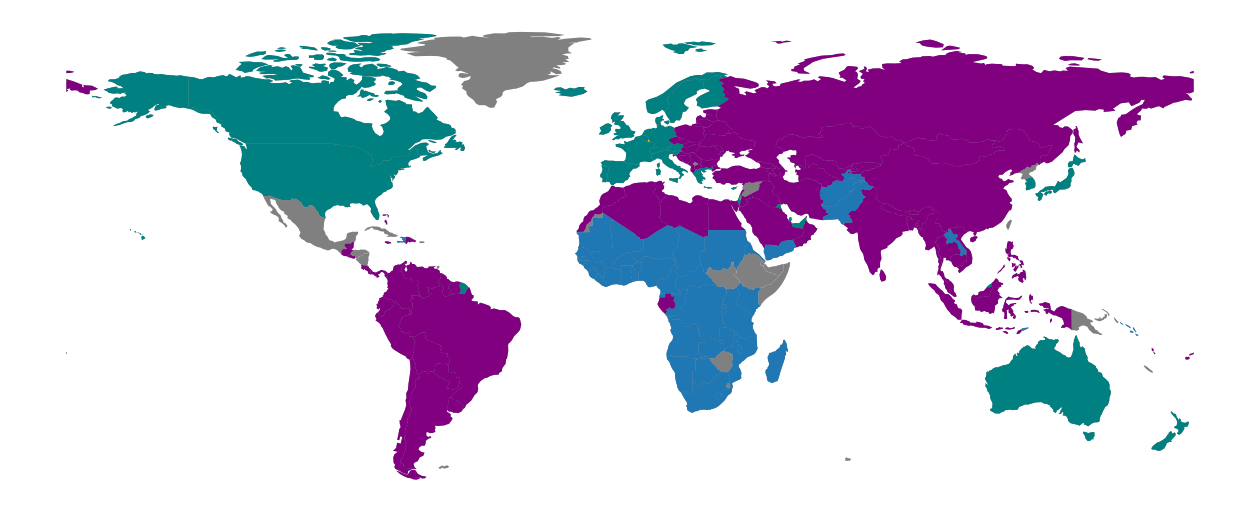

In [8]:
plot_world_map(countries_df, world, kmeans_search.labels_, color_map)

In [9]:
print(kmeans_search.best_params_)

{'kmeans__n_clusters': 4, 'normalizer': 'passthrough'}


#### Agglomerative Clustering

Fr. S. Antarctic Lands not found in regex
S. Sudan not found in regex


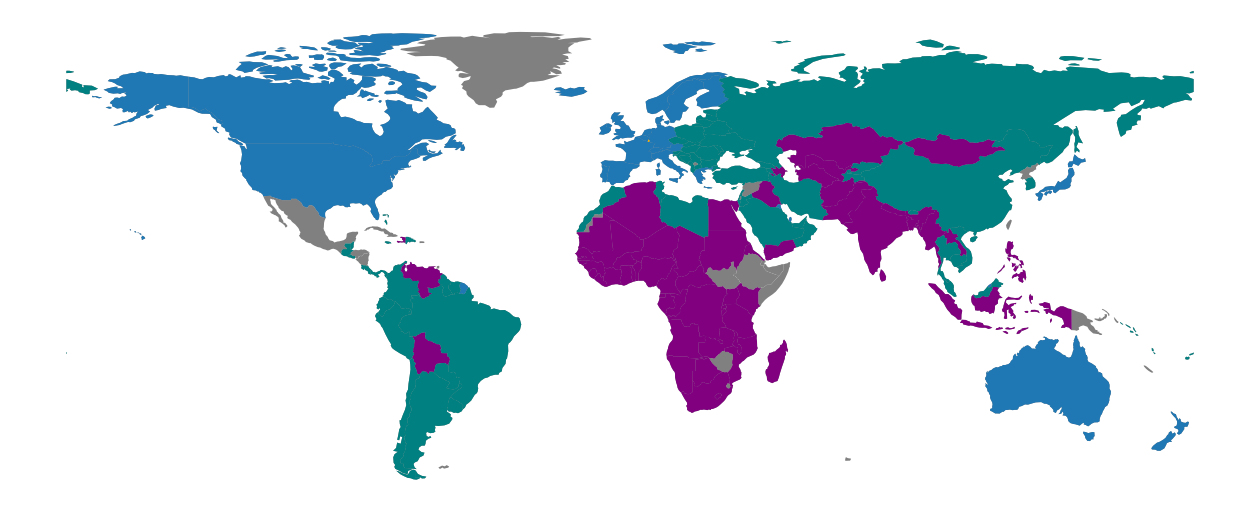

In [10]:
plot_world_map(countries_df, world, aggc_search.labels_, color_map)

In [11]:
print(aggc_search.best_params_)

{'agglomerativeclustering__n_clusters': 4, 'normalizer': 'passthrough'}


#### SpectralClustering

Fr. S. Antarctic Lands not found in regex
S. Sudan not found in regex


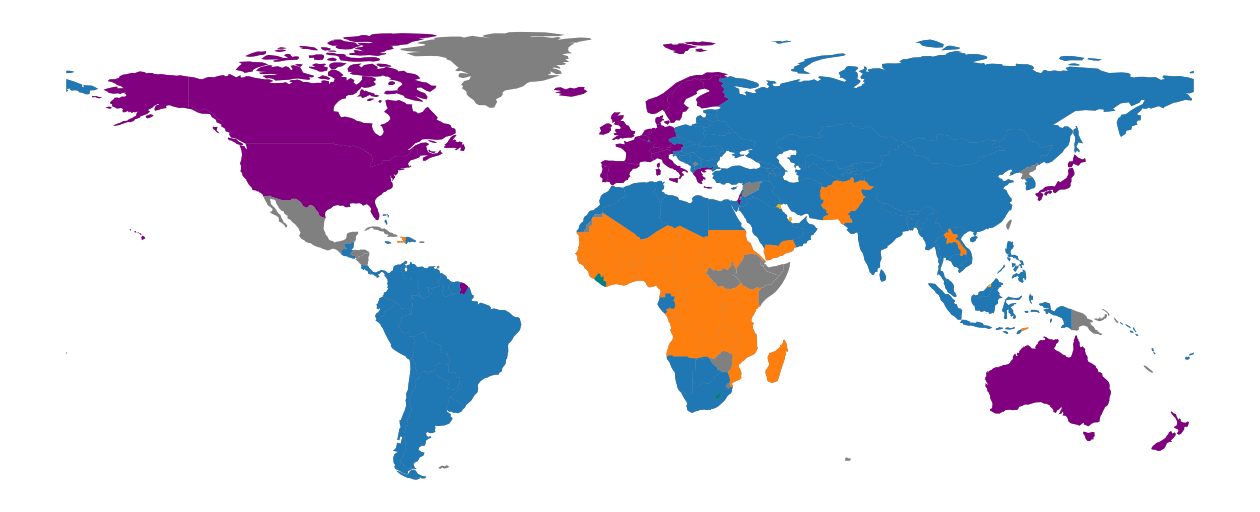

In [12]:
plot_world_map(countries_df, world, spc_search.labels_, color_map)

In [13]:
print(spc_search.best_params_)

{'spectralclustering__n_clusters': 5, 'spectralclustering__n_neighbors': 3}
